# U-Net Template
Supplementary Materials, *Junha Park* <br/>
[Reference](https://www.kaggle.com/c/data-science-bowl-2018/data) : Kaggle data science bowl 2018 Round 1 <br/>

In [2]:
import os
import time
import copy
import torch
import shutil
import pandas as pd
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
from PIL import Image
from skimage import io, transform
import cv2

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch import nn
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensorV2

from torch.autograd import Variable
from torch.optim import Adam, SGD
import torch.nn.functional as F

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
import sys
sys.executable

'/home/mars/anaconda3/envs/molly/bin/python'

### Load Data with Dataset

In [4]:
def get_transforms(mean, std):
    list_transforms = []
    list_transforms.extend(
        [
            HorizontalFlip(p=0.5)
        ]
    )
    list_transforms.extend(
        [
            Normalize(mean = mean, std = std, p=1),
            ToTensorV2(),
        ]
    )
    return Compose(list_transforms)

In [56]:
class Nuclei_dataset(Dataset):
    def __init__(self, path):
        self.path = path
        self.folders = os.listdir(path)
        self.transforms = get_transforms(0.5, 0.5)
    
    def __len__(self):
        return len(self.folders)
    
    def __getitem__(self, idx):
        image_folder = os.path.join(self.path, self.folders[idx], 'images/')
        mask_folder = os.path.join(self.path, self.folders[idx], 'masks/')
        image_path = os.path.join(image_folder, os.listdir(image_folder)[0])
        img = io.imread(image_path)[:,:,:3].astype('float32')
        img = transform.resize(img, (128,128))
        mask = self.get_mask(mask_folder, 128, 128).astype('float32')
        augmented = self.transforms(image = img, mask = mask)
        img = augmented['image']
        mask = augmented['mask']
        #print(mask.shape)
        mask = mask.permute(2,0,1)
        
        return (img, mask)
    
    def get_mask(self, mask_folder, IMG_HEIGHT, IMG_WIDTH):
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
        for mask_ in os.listdir(mask_folder):
            mask_ = io.imread(os.path.join(mask_folder, mask_))
            mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
            mask_ = np.expand_dims(mask_, axis = -1)
            mask = np.maximum(mask, mask_)
        return mask

In [57]:
base_dir = '/home/mars/jupyter-home/Junha Park/train'
data = Nuclei_dataset(base_dir)


In [58]:
print(data.__len__())
data.__getitem__(0)

670


/tmp/ipykernel_30363/2539660355.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)


(tensor([[[-0.9588, -0.9608, -0.9612,  ..., -0.9472, -0.9658, -0.9739],
          [-0.9514, -0.9602, -0.9623,  ..., -0.9449, -0.9625, -0.9719],
          [-0.9351, -0.9517, -0.9566,  ..., -0.9445, -0.9629, -0.9737],
          ...,
          [-0.9767, -0.9782, -0.9817,  ..., -0.9828, -0.9843, -0.9843],
          [-0.9780, -0.9767, -0.9767,  ..., -0.9843, -0.9843, -0.9828],
          [-0.9782, -0.9784, -0.9767,  ..., -0.9843, -0.9843, -0.9841]],
 
         [[-0.9588, -0.9608, -0.9612,  ..., -0.9472, -0.9658, -0.9739],
          [-0.9514, -0.9602, -0.9623,  ..., -0.9449, -0.9625, -0.9719],
          [-0.9351, -0.9517, -0.9566,  ..., -0.9445, -0.9629, -0.9737],
          ...,
          [-0.9767, -0.9782, -0.9817,  ..., -0.9828, -0.9843, -0.9843],
          [-0.9780, -0.9767, -0.9767,  ..., -0.9843, -0.9843, -0.9828],
          [-0.9782, -0.9784, -0.9767,  ..., -0.9843, -0.9843, -0.9841]],
 
         [[-0.9588, -0.9608, -0.9612,  ..., -0.9472, -0.9658, -0.9739],
          [-0.9514, -0.9602,

In [59]:
for img, msk in data:
    print(img.shape)
    print(msk.shape)
    break

torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


/tmp/ipykernel_30363/2539660355.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)


In [60]:
def mask_convert(mask):
    mask = mask.clone().cpu().detach().numpy()
    mask = mask.transpose((1,2,0))
    std = np.array((0.5))
    mean = np.array((0.5))
    mask = std * mask + mean
    mask = mask.clip(0,1)
    mask = np.squeeze(mask)
    return mask

def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    std = np.array((0.5,0.5,0.5))
    mean = np.array((0.5,0.5,0.5))
    image = std*image + mean
    image = image.clip(0,1)
    image = (image*255).astype(np.uint8)
    return image

In [61]:
trainset, valset = random_split(data, [580, 90])
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=valset, batch_size=10)

/tmp/ipykernel_30363/2539660355.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)


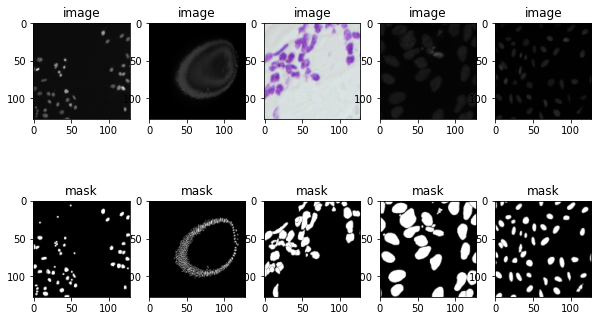

In [62]:
def plot_img(dataloader, no_):
    iter_ = iter(dataloader)
    images, masks = next(iter_)
    images = images.to(device)
    masks = masks.to(device)
    plt.figure(figsize=(10,6))
    for idx in range(no_):
        image = image_convert(images[idx])
        plt.subplot(2, no_, idx+1)
        plt.title('image')
        plt.imshow(image)
    for idx in range(no_):
        mask = mask_convert(masks[idx])
        plt.subplot(2, no_, idx+no_+1)
        plt.title('mask')
        plt.imshow(mask, cmap='gray')
    plt.show()
    
plot_img(train_loader, 5)

In [65]:
class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        # Contraction
        self.dblock1 = self.double_conv(3, 64)
        self.dblock2 = self.double_conv(64, 128)
        self.dblock3 = self.double_conv(128,256)
        self.dblock4 = self.double_conv(256,512)
        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) 
        
        # Inflation
        self.dblock5 = self.double_conv(256 + 512, 256)
        self.dblock6 = self.double_conv(128 + 256, 128)
        self.dblock7 = self.double_conv(128 + 64, 64)

        self.last_layer = nn.Conv2d(64,1,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        conv1 = self.dblock1(x)
        x = self.pool(conv1)

        conv2 = self.dblock2(x)
        x = self.pool(conv2)

        conv3 = self.dblock3(x)
        x = self.pool(conv3)

        conv4 = self.dblock4(x)
        
        x = self.upsample(conv4)

        x = torch.cat([x, conv3], dim=1)

        x = self.dblock5(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        
        x = self.dblock6(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        
        x = self.dblock7(x)

        out = self.last_layer(x)
        # out = self.sigmoid(x)
        return out
    
    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )

In [66]:
model = Unet().to(device)
model

Unet(
  (dblock1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dblock2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dblock3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dblock4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2,

In [67]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        bce_weight = 0.5
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        loss_final = BCE * bce_weight + dice_loss * (1 - bce_weight)
        return loss_final
    
## IOU computation
def iou_(y_pred,y):
    inputs = y_pred.reshape(-1)
    targets = y.reshape(-1)
    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection 
    smooth = 1    
    iou = (intersection + smooth)/(union + smooth)
    return iou

def iou_batch(y_pred,y):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    y_pred = F.sigmoid(y_pred)
    y_pred = y_pred.clone().cpu().detach().numpy()
    y = y.clone().cpu().detach().numpy() 
    
    for pred, label in zip(y_pred, y):
        ious.append(iou_(pred, label))
    iou = np.nanmean(ious)
    return iou    

In [68]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    torch.save(state, checkpoint_path)
    if is_best:
        shutil.copyfile(checkpoint_path, best_model_path)
        
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    valid_loss_min = checkpoint['valid_loss_min']
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

In [69]:
checkpoint_path = '/home/mars/jupyter-home/Junha Park/model'
best_model_path = '/home/mars/jupyter-home/Junha Park/bestmodel/bestmodel.pt'
epochs = 20
criterion = DiceBCELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
valid_loss_min = 3.95275

train_loss,val_loss = [],[]
train_iou,val_iou = [],[]

for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch + 1, epochs))
    start_time = time.time()
     

    
    running_train_loss = []
    running_train_score = []
    for image,mask in train_loader: 
            image = image.to(device,dtype=torch.float)
            mask = mask.to(device,dtype=torch.float)
            
            pred_mask = model.forward(image) # forward propogation
            loss = criterion(pred_mask,mask)
            score = iou_batch(pred_mask,mask)
            optimizer.zero_grad() # setting gradient to zero
            loss.backward()
            optimizer.step()
            running_train_loss.append(loss.item())
            running_train_score.append(score)
                              

    else:           
        running_val_loss = []
        running_val_score = []
        with torch.no_grad():
            for image,mask in val_loader:
                    image = image.to(device,dtype=torch.float)
                    mask = mask.to(device,dtype=torch.float)                            
                    pred_mask = model.forward(image)
                    loss = criterion(pred_mask,mask)
                    score = iou_batch(pred_mask,mask)
                    running_val_loss.append(loss.item())
                    running_val_score.append(score)

                                    
    
    epoch_train_loss,epoch_train_score = np.mean(running_train_loss) ,np.mean(running_train_score)
    print('Train loss : {} iou : {}'.format(epoch_train_loss,epoch_train_score))                       
    train_loss.append(epoch_train_loss)
    train_iou.append(epoch_train_score)
    
    epoch_val_loss,epoch_val_score = np.mean(running_val_loss),np.mean(running_val_score)
    print('Validation loss : {} iou : {}'.format(epoch_val_loss,epoch_val_score))                                
    val_loss.append(epoch_val_loss)
    val_iou.append(epoch_val_score)
    
    # create checkpoint variable and add important data
    checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': epoch_val_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
    
    # save checkpoint
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    ## TODO: save the model if validation loss has decreased
    if epoch_val_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
            # save checkpoint as best model
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)
            valid_loss_min = epoch_val_loss
    
    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch 1/20


/tmp/ipykernel_30363/2539660355.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
/home/mars/anaconda3/envs/molly/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train loss : 0.5904110885899643 iou : 0.14500497600250786
Validation loss : 0.4966915316051907 iou : 0.2373165815543217
Validation loss decreased (3.952750 --> 0.496692).  Saving model ...
4m 49s
Epoch 2/20
Train loss : 0.4339368399874917 iou : 0.26748055894694406
Validation loss : 0.42316050993071663 iou : 0.3167821039743521
Validation loss decreased (0.496692 --> 0.423161).  Saving model ...
4m 43s
Epoch 3/20
Train loss : 0.41821477074047614 iou : 0.31838400430095665
Validation loss : 0.5134963393211365 iou : 0.2741511409593193
4m 45s
Epoch 4/20
Train loss : 0.3531983407406971 iou : 0.3766296065145763
Validation loss : 0.2686196168263753 iou : 0.4572452862184487
Validation loss decreased (0.423161 --> 0.268620).  Saving model ...
4m 46s
Epoch 5/20
Train loss : 0.2934944547455886 iou : 0.48411349513576285
Validation loss : 0.2399196591642168 iou : 0.49514479019126667
Validation loss decreased (0.268620 --> 0.239920).  Saving model ...
4m 50s
Epoch 6/20
Train loss : 0.28567374497652054

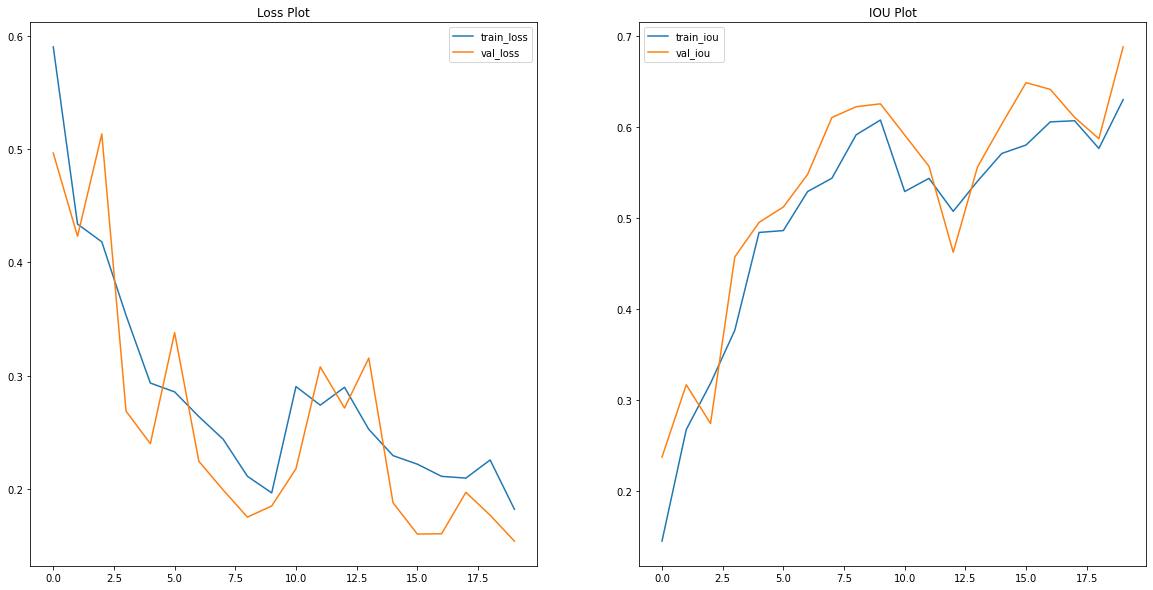

In [70]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(train_loss,label='train_loss')
plt.plot(val_loss,label='val_loss')
plt.legend()
plt.title('Loss Plot')
plt.subplot(1,2,2)
plt.plot(train_iou,label='train_iou')
plt.plot(val_iou,label='val_iou')
plt.legend()
plt.title('IOU Plot')
plt.show()

In [ ]:
#loading the saved model
model, optimizer, start_epoch, valid_loss_min = load_ckp(checkpoint_path, model, optimizer)

In [ ]:
iter_ = iter(val_loader)
image,mask = next(iter_)
image = image.to(device,dtype=torch.float)
mask = mask.to(device,dtype=torch.float)
y_pred = model.forward(image)


plt.figure(figsize=(20,15))
for i in range(0,5):
    plt.subplot(3,5,i+1)
    plt.title('Actual image')
    plt.imshow(image_convert(image[i]))
for i in range(0,5):
    plt.subplot(3,5,i+5+1)
    plt.title('Actual mask')
    plt.imshow(mask_convert(mask[i]),cmap='gray')
for i in range(0,5):
    plt.subplot(3,5,i+10+1)
    plt.title('Predicted mask')
    plt.imshow(mask_convert(y_pred[i]),cmap='gray')
plt.show()